# 1. Dimensionality Reduction & Principal Component Analysis 
Principal component analysis is an incredibly powerful technique that all data scientists should be aware of in the plight against the **curse of dimensionality**. Before we dig into the mechanics of it, however, we need to define what the curse of dimensionality is to begin with.

## 1.1 The Curse of Dimensionality
To understand the curse of dimensionality, we can start with an example. We will say that we are given a dataset that we want to perform some machine learning with (make some sort of prediction) and that data set has two attributes: `height` and `urefu` (whatever `urefu` is). Now, we can pose the question: what is the dimensionality of this dataset? Of course we can immediately say that this is a 2 dimensional dataset.  

At this point, we decide to start plotting this dataset, and we end up with the following:

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

# Seaborn Plot Styling
sns.set(style="white", palette="husl")
sns.set_context("talk", rc={"lines.linewidth": 1})
sns.set_style("ticks")

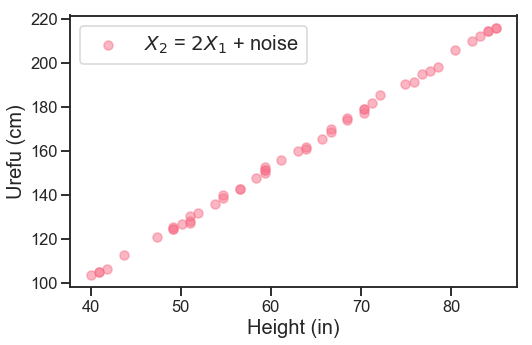

In [3]:
population_points = 100
sample_points = population_points // 2
population_height_inches = np.linspace(40, 85, sample_points)
sample_height_inches = np.random.choice(population_height_inches, (sample_points))
noise = np.random.normal(0,1,sample_points) 
urefu = sample_height_inches * 2.54 + noise

fig, ax = plt.subplots(figsize=(8,5))
    
plt.scatter(sample_height_inches, urefu, alpha=0.5)

"""Create legend & labels"""
ax.legend(['$X_2$ = $2X_1$ + noise'], fontsize=20)
ax.set_xlabel('Height (in)', fontsize=20)
ax.set_ylabel('Urefu (cm)', fontsize=20)

plt.show()

We immediately see from the plot above that these two attributes are very correlated, but we still are dealing with a 2-dimensional dataset. However, then a colleague comes by, and they happen to speak Swahili, and they let us know that `urefu` in Swahili stands for `height`. At this point we realize that our dataset only has one unique dimension! In reality the `height` and the `urefu` are just different names for the same thing; yes the numbers may be different, with one being in inches and the other in centimeters, and their is slight variation due to noise in the observations due to the measuring device, but they are the same thing.

Now this is an extreme example, but it is meant to be illustrative of the following:

> When we look at datasets, we tend to view them on the surface, having only the slightest of ideas about what the attributes represent. Hence, until you do know what the attributes represent you don't know how many dimensions you have. 

This 2 dimensional problem is magnified when we start dealing with datasets of much higher dimensionality. For instance, if we are dealing with images we have on the order of $10^4$ pixels, and if it is text $10^6$ words. This is the way that we record pixels and text. However, in reality, the true dimensionality may be _much_ lower. Our data may in actuality be straddling a low dimensional manifold in a high dimensional space. For example, let's say for a second that we are dealing with hand written digits, where each observation is a 28x28 bitmap. Several can be seen below: 

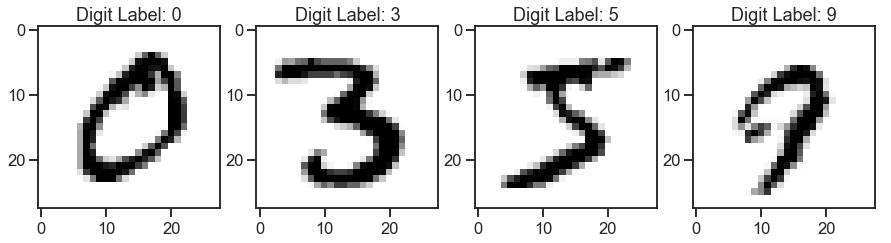

In [4]:
import pylab 
import pandas as pd
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home='datasets/')
y = pd.Series(mnist.target).astype('int').astype('category')
X = pd.DataFrame(mnist.data)

fig = pylab.subplots(figsize=(15,10))

pylab.subplot(141)
first_image = X.loc[0,:]
first_label = y[0]
# 784 columns correspond to 28x28 image
plottable_image = np.reshape(first_image.values, (28, 28))
pylab.imshow(plottable_image, cmap='gray_r')
pylab.title('Digit Label: {}'.format(first_label))

pylab.subplot(142)
first_image = X.loc[18625,:]
first_label = y[18625]
# 784 columns correspond to 28x28 image
plottable_image = np.reshape(first_image.values, (28, 28))
pylab.imshow(plottable_image, cmap='gray_r')
pylab.title('Digit Label: {}'.format(first_label))

pylab.subplot(143)
first_image = X.loc[30596,:]
first_label = y[30596]
# 784 columns correspond to 28x28 image
plottable_image = np.reshape(first_image.values, (28, 28))
pylab.imshow(plottable_image, cmap='gray_r')
pylab.title('Digit Label: {}'.format(first_label))

pylab.subplot(144)
first_image = X.loc[69970,:]
first_label = y[69970]
# 784 columns correspond to 28x28 image
plottable_image = np.reshape(first_image.values, (28, 28))
pylab.imshow(plottable_image, cmap='gray_r')
pylab.title('Digit Label: {}'.format(first_label))

pylab.show()

A 28x28 image means that their are $\{0,1\}^{(28x28)}$ possible events ($2^{784}$). Of this enormous number of events, we will never see that vast majority! The actual digits represent a _tiny_ fraction. For example, below there are four random examples from the space of possible events:

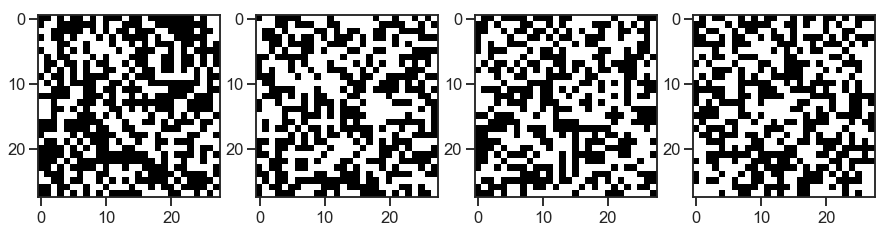

In [5]:
mapper = np.vectorize(lambda z: 0 if z < 0.5 else 1)

fig = pylab.subplots(figsize=(15,10))

Z = np.random.random((28,28))   # Test data
Z_binary = mapper(Z)
pylab.subplot(141)
pylab.imshow(Z_binary, cmap='binary', interpolation='nearest')

Z = np.random.random((28,28))   # Test data
Z_binary = mapper(Z)
pylab.subplot(142)
pylab.imshow(Z_binary, cmap='binary', interpolation='nearest')

Z = np.random.random((28,28))   # Test data
Z_binary = mapper(Z)
pylab.subplot(143)
pylab.imshow(Z_binary, cmap='binary', interpolation='nearest')

Z = np.random.random((28,28))   # Test data
Z_binary = mapper(Z)
pylab.subplot(144)
pylab.imshow(Z_binary, cmap='binary', interpolation='nearest')

pylab.show()

We can clearly see that the above examples look nothing like digits. This should spark the thought:

> Do we need to use the original representation, or can we transform it in order to prevent wasting our ML algorithms on events that don't look anything like what we want to model?

In reality, the true dimensionality of digits is _not_ $2^{784}$, it actually has something to do with pen strokes; how much variation is in ones hand as they write a particular digit on paper. The dimensionality of that is _much lower_ than the original representation. 

This still begs the question, why is this that big of a deal? Well, the vast majority of machine learning algoritihms are statistical in nature, and will perform some type of counting (i.e. decision trees) in various regions of space. The issue with high dimensionality is that as our the number of dimensions grows, _we have fewer observations per region_. 

This can be thought of as follows: Assume we have 100 observations, and we have only 1 dimension, and it can take on the value $\{1,2,3\}$. This means that we have 3 possible values, for 100 observations, hence ~33.3 observations for each value. However, now lets say we add a second dimesion, that also have three possible values, $\{a,b,c\}$. Now, we have _9 possible_ value pairs, and 100 observations, leaving us with ~11 observations per pair. If we just add one more dimension, we end up with $3^3 = 27$ possible pairs in the input space, and 3.7 observations per pair. This _quickly_ can get out of hand as the dimensionality increases further, eventually meaning that we can't possibly have enough observations in a region to be sure of our estimate.

In general, statistics need repetition. So, even if we do get lucky enough to have a single data point at a certain location in the input space, is that one example enough? It is similar to saying that you flip a coin once and it comes up heads, and you then conclude that $p(head) = 100\%$. 

## 1.2 How to deal with High Dimensionality
### A. Domain knowledge 
There are a few main ways to deal with high dimensionality. The first of which is to simply use domain knowledge and feature engineering. For instance, in computer vision the raw pixels are rarely used directly-they are generally transformed first (for example via SIFT). The same goes for raw speech-it may be transformed via MFCC. 

### B. Simplifying Assumptions
We also can make simplifying assumptions. For instance, **Naive Bayes** makes an assumption about indepedence, specifically that each dimension is independent of the others. Pictorally, this can be seen below. In the first plot, we have a 2-dimensional dataset, consisting of attributes $X_1$ and $X_2$. If we are counting the frequencies for $X_1$, the independence assumption allows us to ignore $X_2$ entirely. We can view this as though no matter the value of $X_2$, we use the same counts of $X_1$ (second plot), or that we are collapsing the $X_2$ variable entirely and only dealing with $X_1$. The end result is that we have a greater density of observations.

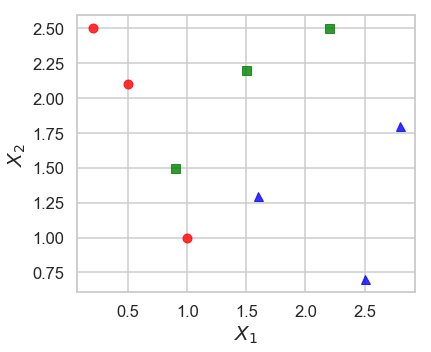

In [6]:
sns.set_style("whitegrid")
fig, (ax1) = plt.subplots(1, figsize=(6, 5))       # Create figure and axis object   
ax1.set_ylabel('$X_2$', fontsize=20)
ax1.set_xlabel('$X_1$', fontsize=20)
plt.tight_layout()

red_class = [(1,1), (0.5, 2.1), (0.2, 2.5)]
green_class = [(0.9,1.5), (1.5, 2.2), (2.2, 2.5)]
blue_class = [(1.6,1.3), (2.5, 0.7), (2.8, 1.8)]

for point in red_class:
    marker, = ax1.plot(point[0], point[1], 'or', alpha=0.8)
    
for point in green_class:
    marker, = ax1.plot(point[0], point[1], 'gs',  alpha=0.8)
        
for point in blue_class:
    marker, = ax1.plot(point[0], point[1], 'b^',  alpha=0.8)

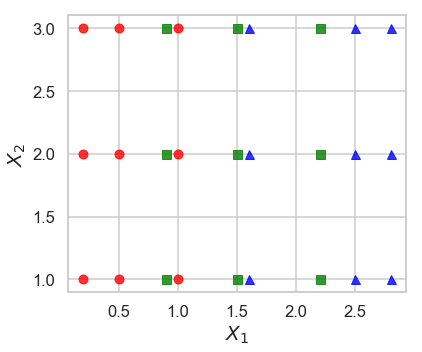

In [7]:
fig, (ax1) = plt.subplots(1, figsize=(6, 5))       # Create figure and axis object   
ax1.set_ylabel('$X_2$', fontsize=20)
ax1.set_xlabel('$X_1$', fontsize=20)
plt.tight_layout()

for x_2 in range(1,4):
    for point in red_class:
        marker, = ax1.plot(point[0], x_2, 'or', alpha=0.8)

    for point in green_class:
        marker, = ax1.plot(point[0], x_2, 'gs',  alpha=0.8)

    for point in blue_class:
        marker, = ax1.plot(point[0], x_2, 'b^',  alpha=0.8)

In [8]:
# sns.set(style="white", palette="husl")
# sns.set_context("talk", rc={"lines.linewidth": 1})
# sns.set_style("ticks")

# # set up the figure
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.set_xlim(0,3)
# ax1.set_ylim(-0.1,0.1)

# # draw lines
# xmin = -10
# xmax = 10
# y = 0
# height = 1

# for x_2 in range(1):
#     for point in red_class:
#         marker, = ax1.plot(point[0], x_2, 'or', alpha=0.8)

#     for point in green_class:
#         marker, = ax1.plot(point[0], x_2, 'gs',  alpha=0.8)

#     for point in blue_class:
#         marker, = ax1.plot(point[0], x_2, 'b^',  alpha=0.8)

# plt.hlines(y, xmin, xmax, color='grey')
# ax1.set_xlabel('$X_1$', fontsize=20)
# ax1.axes.get_yaxis().set_ticks([])


We can also make the assumption of smoothness, which just means that observations propagate to neighboring regions in space. This can be seen below; we have the same set of observations as we did before, but now each observation "spills over" into neighboring regions, allowing us to get further with few datapoints. 

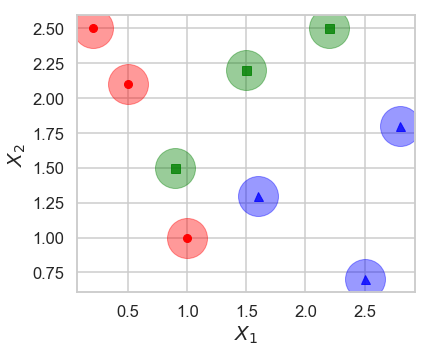

In [9]:
sns.set_style("whitegrid")
fig, (ax1) = plt.subplots(1, figsize=(6, 5))       # Create figure and axis object   
ax1.set_ylabel('$X_2$', fontsize=20)
ax1.set_xlabel('$X_1$', fontsize=20)
plt.tight_layout()

red_class = [(1,1), (0.5, 2.1), (0.2, 2.5)]
green_class = [(0.9,1.5), (1.5, 2.2), (2.2, 2.5)]
blue_class = [(1.6,1.3), (2.5, 0.7), (2.8, 1.8)]

for point in red_class:
    marker, = ax1.plot(point[0], point[1], 'or', markersize=8, alpha=1)
    marker, = ax1.plot(point[0], point[1], 'or', markersize=40, alpha=0.4)
    
for point in green_class:
    marker, = ax1.plot(point[0], point[1], 'gs',  alpha=0.8)
    marker, = ax1.plot(point[0], point[1], 'go', markersize=40, alpha=0.4)

        
for point in blue_class:
    marker, = ax1.plot(point[0], point[1], 'b^',  alpha=0.8)
    marker, = ax1.plot(point[0], point[1], 'bo', markersize=40, alpha=0.4)


### C. Reduce Dimensionality of the data
The final option that we have is to reduce the dimensionality of the data. Simply put, this means that we take the data as it comes in with a specific number of dimensions, and we try to come up with a new set of dimensions which is smaller than that which came in. The overall goal of dimensionality reduction could be stated as follows:

> **Goal**: Represent our class instances with fewer variables, while preserving as much **structure** in the data as possible. 

The term structure above is just meant to stand for anything in the data that is useful for the task at hand. For instance, if we were performing regression, then structure would be anything in the data that was useful for performing regression. Likewise if we were performing classification. 

So, how exactly can we reduce the dimensionality of the data? The simplest method is known as **Feature Selection**. The idea here is that we have an observation which is represented by $d$ attributes:

$$X = \{ X_1, X_2, X_3,...,X_{d-1}, X_d\}$$

And we are going to pick a subset of those attributes that we reason to be good _predictors_. In other words, we want to pick the attributes that do the best job of encoding our class instances (for whatever purpose we have):

$$X = \{ X_2, X_{d-1}\}$$

Keep in mind that in feature selection we are _throwing away_ portions of the data. On the other hand we can perform **Feature Extraction**. With this method we make use of all of the original attributes and combine them in some way to form a smaller number of attributes:

<img src="https://drive.google.com/uc?id=1E5HWGY9fKEfjkxjtcdMA--BsbCNjQdm9">

Mathematically, this can be written as:

$$E_i = f(X_1,...X_d)$$

Often times this will end up being a **linear combination** of the original dimensions. And that is essentially what **Principal Component Analysis** is.

# 2. Principal Component Analysis
Principal Component Analysis, commonly referred to as **PCA**, is a method to define a new set of dimensions. It does this by defining a set of **principal components**, where the 1st component holds the direction of greatest variability in the data, and the 2nd is perpendicular to the first, holding the greatest variability of what is left. This can continue up until $d$, the original dimensionality. 

For instance, if we look at the plot below we can see that our data essentially falls along a sheet in the 3d space. This means that the vast majority of the 3d space remains unused, and we can reduce our dimensionality by finding two components along the sheets planes. We can see what our principal components should be in the 2nd plot, the green being the first principal component, the magenta being the second.

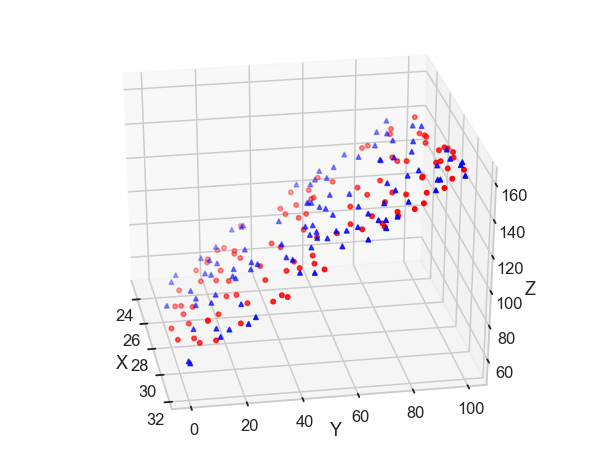

In [10]:
# Fixing random state for reproducibility
np.random.seed(19680801)

def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = 2*xs + ys 
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.view_init(azim=-10)    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

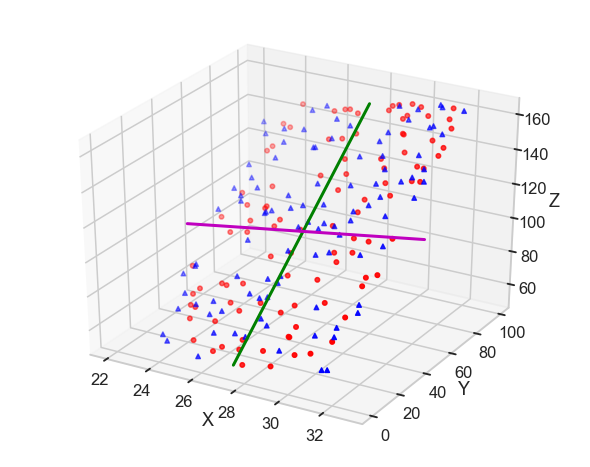

In [11]:
# Fixing random state for reproducibility
np.random.seed(19680801)

def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = 2*xs + ys 
    ax.scatter(xs, ys, zs, c=c, marker=m)

x_principal_1 = np.full(100, 27.5)
y_principal_1 = np.arange(0, 100, 1)
z_principal_1 = 2*x_principal_1 + y_principal_1
ax.plot(x_principal_1, y_principal_1, z_principal_1, c='g', linewidth=3.0)

y_principal_2 = np.full(12, 50)
x_principal_2 = np.arange(22, 34, 1)
z_principal_2 = 2*x_principal_2 + y_principal_2
ax.plot(x_principal_2, y_principal_2, z_principal_2, c='m', linewidth=3.0)
    
ax.view_init(azim=-60)    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

The main idea here is that we are looking for the dimension that has the greatest variance, and then we look for a dimension that is perpendicular to the first, with the greatest remaining variance. Once we come up with these new dimensions, we change the coordinate system so that each datapoint is in the new set of dimensions. In this case, we can see our transformed data into the dimensions of the principal components below:

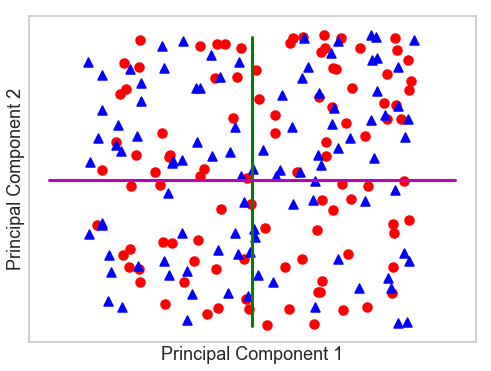

In [13]:
# Fixing random state for reproducibility
np.random.seed(19680801)

def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
#     zs = 2*xs + ys 
    ax.scatter(xs, ys, c=c, marker=m)

x_principal_1 = np.full(100, 27.5)
y_principal_1 = np.arange(0, 100, 1)
z_principal_1 = 2*x_principal_1 + y_principal_1
ax.plot(x_principal_1, y_principal_1, c='g', linewidth=3.0)

y_principal_2 = np.full(12, 50)
x_principal_2 = np.arange(22, 34, 1)
z_principal_2 = 2*x_principal_2 + y_principal_2
ax.plot(x_principal_2, y_principal_2, c='m', linewidth=3.0)
     
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.axes.get_yaxis().set_ticks([])
ax.axes.get_xaxis().set_ticks([])
plt.show()

### 2.1 Why try and maximize variance?
The question that will most definitely arise at this point is: why are we trying to pick principal components that maximize variance? Well, the main intuition behind this is that high variance dimensions will help to preserve the relative distances between data points; i.e., they help preserve the **structure** of the data. Visually, this can be seen below:

<img src="https://drive.google.com/uc?id=1Sv0eW3b6THnVHDBlCj9XCZsqZ0cAxefF" width="500">

Above, we can see that points in the original space ($X_1$ and $X_2$) that were far away from each other, are still pretty far away from each other once projected onto $e$. If we had chosen another principal component where points were projected on top of each other, then we would not have preserved the original distances and structure. 

The reason that we care about preserving distances is that in classification, nearby things should be _similar_, and hence if we lose the original distances we may risk losing classifcation power. By picking the dimension with the highest variance, we will preserve the distance as much as possible. 

## 2.2 Finding the Principal Components
Let's now discuss how we go about finding the principal components. We will start wit the data set shown below. It consists of two dimensions, $X_1$ and $X_2$.

In [14]:
num_points = 100
x_1 = np.linspace(0, 6, num_points)
noise = np.random.normal(0,1,num_points)
x_2 = 2*x_1 + noise

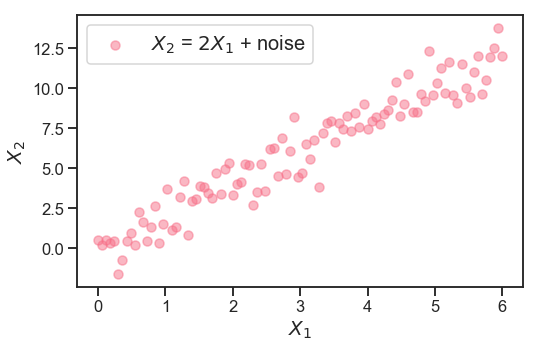

In [16]:
# Seaborn Plot Styling
sns.set(style="white", palette="husl")
sns.set_context("talk", rc={"lines.linewidth": 1})
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8,5))
    
plt.scatter(x_1, x_2, alpha=0.5)

"""Create legend & labels"""
ax.legend(['$X_2$ = $2X_1$ + noise'], fontsize=20)
ax.set_xlabel('$X_1$', fontsize=20)
ax.set_ylabel('$X_2$', fontsize=20)

plt.show()

### 2.2.1 Center the Data
The first thing that we want to do is center the data so that the origin is dead in the center of the data cloud. To do this, we simply subtract the mean from each dimension. 

In [17]:
mu_x_1 = x_1.mean()
mu_x_2 = x_2.mean()
print('Mean of x_1: ', mu_x_1, '\nMean of x_2: ', mu_x_2)

Mean of x_1:  3.0 
Mean of x_2:  6.015274363310343


In [18]:
centered_x_1 = x_1 - mu_x_1
centered_x_2 = x_2 - mu_x_2

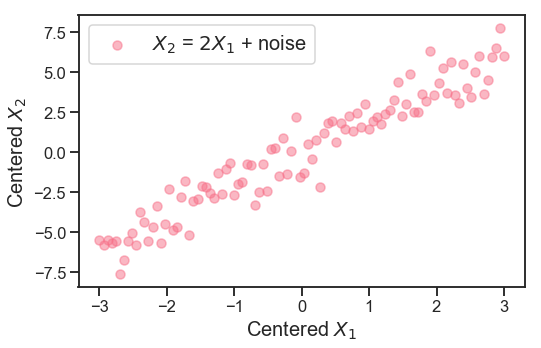

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(centered_x_1, centered_x_2, alpha=0.5)

"""Create legend & labels"""
ax.legend(['$X_2$ = $2X_1$ + noise'], fontsize=20)
ax.set_xlabel('Centered $X_1$', fontsize=20)
ax.set_ylabel('Centered $X_2$', fontsize=20)

plt.show()

### 2.2.2 Compute the Covariance Matrix
We can now compute the covariance matrix $\Sigma$. The covariance between two attributes is essentially an indication as to whether they change together or in opposite directions. The covariance matrix is defined as:

$$cov(X_1,X_2) = E \big[(X_1 - E[X_1])(X_2 - E[X_2])\big]$$

Where $E$ is the expected value, and hence in this case the mean. This allows us to rewrite the above as:

$$cov(X_1, X_2) = \frac{1}{N} \sum_i^N (X_1^i - E[X_1])(X_2^i - E[X_2])$$

And $E[X_1]$ is simply the expected value of $X_1$, in which case as a random variable that simplifies to the mean of $X_1$, $\mu_{X_1}$. The same goes for $X_2$:

$$cov(X_1, X_2) = \frac{1}{N} \sum_i^N (X_1^i - \mu_{X_1})(X_2^i - \mu_{X_2})$$

Finally, remember that we already have centered the data by subtracting the mean in the prior step, so that is no longer necessary, reducing our equation to:

$$cov(X_1, X_2) = \frac{1}{N} \sum_i^N (X_1^i)(X_2^i)$$

Now, one final point: when calculating the covariance matrix we will need to determine how $X_1$ varies with $X_2$, but also how $X_2$ varies with $X_1$ (they will be the same), and then how $X_1$ and $X_2$ vary with themselves (the variance). We can write a simple function to do just that:

In [20]:
def calculate_covariance(a,b):
    """a and b are both numpy arrays."""
    return (a*b).sum() / len(a)

In [21]:
print('Covariance between X_1 and X_2: ', calculate_covariance(centered_x_1, centered_x_2))
print('Covariance between X_2 and X_1: ', calculate_covariance(centered_x_2, centered_x_1))
print('Variance between X_1 and X_1: ', calculate_covariance(centered_x_1, centered_x_1))
print('Variance between X_2 and X_2: ', calculate_covariance(centered_x_2, centered_x_2))

Covariance between X_1 and X_2:  6.218551233457625
Covariance between X_2 and X_1:  6.218551233457625
Variance between X_1 and X_1:  3.0606060606060606
Variance between X_2 and X_2:  13.687328145980187


We can quickly compare our results to the built in covariance matrix function, `np.cov`, supplied from numpy:

In [22]:
covariance_matrix = np.cov(centered_x_1, centered_x_2, bias=True)
print('Numpy calculated covariance matrix: \n', covariance_matrix)

Numpy calculated covariance matrix: 
 [[ 3.06060606  6.21855123]
 [ 6.21855123 13.68732815]]


Looks like our function lines up perfectly. For a quick sanity check, do these values make sense? We have found a variance of 3.06 for $X_1$ and 13.9 for $X_2$. That seems reasonable, considering our points are clearly more spread out in $X_2$. And we then found a positive covariance of 6.17 when relating $X_1$ to $X_2$; this also makes sense considering our points do clearly seem to co-vary positively. 

### 2.2.3 Multiplying by the covariance matrix
Now, let's say for a moment that we have the following vectors (red, green, and blue below), which correspond to our points in the cartesian plane:

```
vector_red = np.array([[-0.4], [0.6]])   # (-0.4, 0.6)
vector_green = np.array([[.85], [-0.6]]) # (0.85, -0.6)
vector_blue = np.array([[0.05], [-2.0]]) # (0.05, -2.0) 
```

In [23]:
colors = ['r', 'g', 'b']
vector_red = np.array([[-0.4], [0.6]])
vector_green = np.array([[.85], [-0.6]])
vector_blue = np.array([[0.05], [-2.0]])
vectors = [[vector_red, vector_green, vector_blue]]

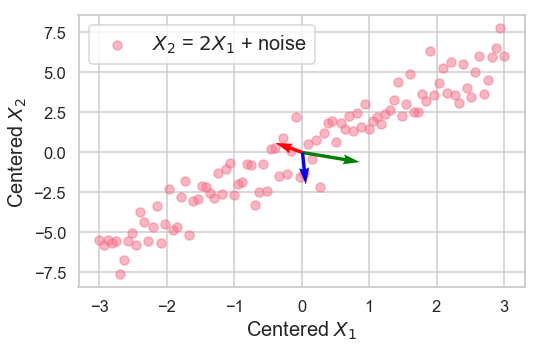

In [25]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(centered_x_1, centered_x_2, alpha=0.5)

for idx, v in enumerate(vectors[0]):
    ax.quiver([0], [0], [v[0]], [v[1]], angles='xy', scale_units='xy', scale=1, color=[colors[idx]])

"""Create legend & labels"""
ax.legend(['$X_2$ = $2X_1$ + noise'], fontsize=20)
ax.set_xlabel('Centered $X_1$', fontsize=20)
ax.set_ylabel('Centered $X_2$', fontsize=20)

plt.show()

Now, we had just found the covariance matrix a moment ago. What would the result be if we transformed our vectors above by the covariance matrix (via a matrix multiplication)? Let's take a look:

In [26]:
vectors.append([covariance_matrix.dot(v) for v in vectors[-1]])

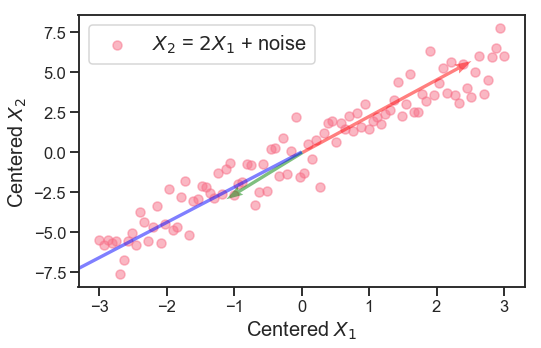

In [27]:
sns.set(style="white", palette="husl")
sns.set_context("talk", rc={"lines.linewidth": 2})
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(centered_x_1, centered_x_2, alpha=0.5)

for idx, v in enumerate(vectors[-1]):
    ax.quiver([0], [0], [v[0]], [v[1]], angles='xy', scale_units='xy', scale=1, color=[colors[idx]], alpha=0.5)

"""Create legend & labels"""
ax.legend(['$X_2$ = $2X_1$ + noise'], fontsize=20)
ax.set_xlabel('Centered $X_1$', fontsize=20)
ax.set_ylabel('Centered $X_2$', fontsize=20)

plt.show()

Ahh! Very interesting; it appears as though that transformation seemed to turn our vectors towards the direction of greatest variance in the data. Let's perform that matrix multiplication a second time (on the transformed vectors):

In [28]:
vectors.append([covariance_matrix.dot(v) for v in vectors[-1]])

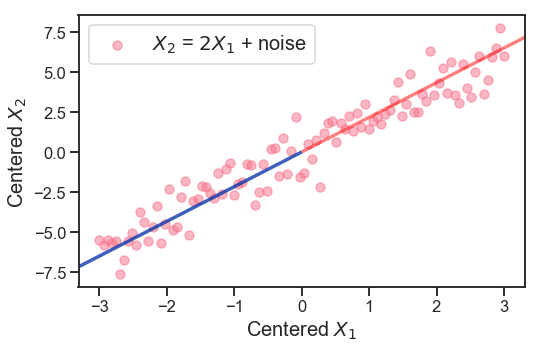

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(centered_x_1, centered_x_2, alpha=0.5)

for idx, v in enumerate(vectors[-1]):
    ax.quiver([0], [0], [v[0]], [v[1]], angles='xy', scale_units='xy', scale=1, color=[colors[idx]], alpha=0.5)

"""Create legend & labels"""
ax.legend(['$X_2$ = $2X_1$ + noise'], fontsize=20)
ax.set_xlabel('Centered $X_1$', fontsize=20)
ax.set_ylabel('Centered $X_2$', fontsize=20)

plt.show()

Our vectors seems to be be perfectly in line with the direction of greatest variance now! It seems to be that our vectors were rotated in the direction of greatest variance, while subsequently having a greater magnitude after each transformation! Now, what is equally interesting is that our vectors appear to be _converging_ to a specific slope! Let's take a look at each vector:

In [30]:
for idx, color in enumerate(['Red', 'Green', 'Blue']):
    print('\n'+ color + 'Vector: ')
    for i in range(len(vectors)):
        print(f'Slope at t = {i}: ', vectors[i][idx][1][0] / vectors[i][idx][0][0] )


RedVector: 
Slope at t = 0:  -1.4999999999999998
Slope at t = 1:  2.283698223829599
Slope at t = 2:  2.1710401053762527

GreenVector: 
Slope at t = 0:  -0.7058823529411765
Slope at t = 1:  2.590817946201857
Slope at t = 2:  2.1740293893159954

BlueVector: 
Slope at t = 0:  -40.0
Slope at t = 1:  2.2031561170614564
Slope at t = 2:  2.1701434142246483


We can clearly see that they each are converging to a specific slope, `~2.15`. So the slope is cleary getting closer and closer to _something_, and if we look at our plot we can see that that is what we would pick out as the dimension of greatest variance. Put another way, it is the dimension where the data points seem to be spread out the most. 

This is definitely an interesting behavior; we have taken a random vector(s), multiplied them by the covariance matrix, and that appears to have turned it towards the dimension of the greatest variance. 

So, we can see that by iteratively multiplying these random vectors by the covariance matrix we have found the dimension of greatest variance that we would have also found via visual inspection. There is another way that we can go about this though! What we are actually looking for are vectors that are not _turned_ when multiplied by the covariance matrix. By definition those are simply our **eigenvectors**! The eigenvector equation can be seen below:

$$\Sigma v = \lambda v$$

Here we transform a vector $v$ by the covariance matrix, $\Sigma$, and if $v$ is an eigenvector it simply is _scaled_ by its eigenvalue (and not rotated). Another way to think about this is that $v$ remains on its _span_. So, what we have come to discover is that our principal components are actually our eigenvectors with the largest eigenvalues! 

### Finding the Eigenvalues and Eigenvectors
So, how do we actually go about finding the eigenvalues and eigenvectors? The mechanical process of doing so by hand is covered in any introductory linear algebra course and countless tutorials, and to be honest not entirely enlightening. We will do so below via numpy's `linalg.eig(A)` function:

In [31]:
e_val, e_vec = np.linalg.eig(covariance_matrix)
print('Eigen Values: ', e_val)
print('Eigen Vectors: ', e_vec)

Eigen Values:  [ 0.19459152 16.55334269]
Eigen Vectors:  [[-0.9081863  -0.41856617]
 [ 0.41856617 -0.9081863 ]]


We can then see where they land in our plot:

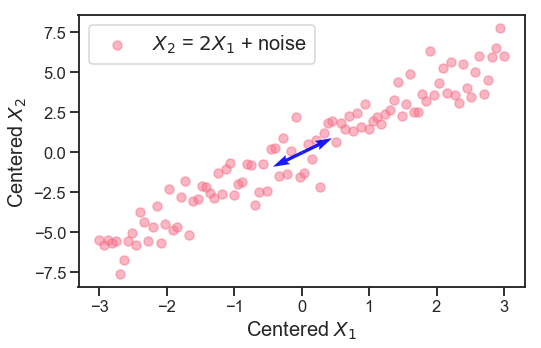

In [32]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(centered_x_1, centered_x_2, alpha=0.5)


ax.quiver([0], [0], [0.44], [0.897], angles='xy', scale_units='xy', scale=1, color=[colors[idx]], alpha=0.9)
ax.quiver([0], [0], [-0.44], [-0.897], angles='xy', scale_units='xy', scale=1, color=[colors[idx]], alpha=0.9)

"""Create legend & labels"""
ax.legend(['$X_2$ = $2X_1$ + noise'], fontsize=20)
ax.set_xlabel('Centered $X_1$', fontsize=20)
ax.set_ylabel('Centered $X_2$', fontsize=20)

plt.show()

### 2.2.4 Why are Eigenvectors in along the direction of greatest variance?
At this point the following question surely must be going through your mind:

> Why does the eigenvector represent the direction of greatest variance? 

To determine this we are going to look at the visualization below. For now, we are going to just assume that the vector $e$ is just any vector (although, we are going to prove that it is our eigenvector). We are going to be projecting our points, $x_1, x_2, x_3$, onto the vector $e$. We are then going to be measuring the _variance_ of the projections. What exactly does that mean? Well, we have three data points in the original space, and they can be projected into the space associated with $e$ by doing a dot product (the projections are shown via dotted lines). By definition, the dot product is:

$$x^T \cdot e = \sum_{j=1}^d x_{ij} e_j$$

It will result in a _single number_ which tells us _where_ the projection is along $e$. This number is a scalar, not a vector. In our case it looks like our projects result in the numbers ~$1, 3, 3.5$, which makes calculating the variance very easy. 

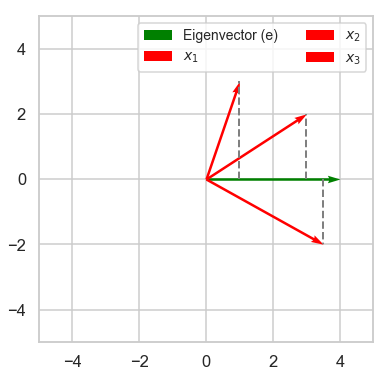

In [37]:
sns.set_style("whitegrid")
sns.set_context("talk", rc={"lines.linewidth": 2})
fig, ax = plt.subplots(figsize=(6,6))

ax.quiver([0], [0], [4], [0], angles='xy', scale_units='xy', scale=1, color=['g']) # e 
ax.quiver([0], [0], [1], [3], angles='xy', scale_units='xy', scale=1, color=['r']) # x1
ax.quiver([0], [0], [3], [2], angles='xy', scale_units='xy', scale=1, color=['r']) # x2
ax.quiver([0], [0], [3.5], [-2], angles='xy', scale_units='xy', scale=1, color=['r']) # x3

plt.vlines(1, ymin=0, ymax=3, linestyle='--', color='grey') # x1 proj
plt.vlines(3, ymin=0, ymax=2, linestyle='--', color='grey') # x2 proj
plt.vlines(3.5, ymin=0, ymax=-2, linestyle='--', color='grey') # x3 proj

ax.legend(['Eigenvector (e)', r'$x_1$', r'$x_2$', r'$x_3$'], fontsize=14, ncol=2)

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

The standard definition for variance is:

$$\frac{1}{n} \sum_{k=1}^n \Big(x_k - \mu\Big)^2$$

And in our case we know that each specific $x_k$ (the resulting projection of $x_i$ onto $e$) is calculated via the dot product from above. That leaves us with a final variance equation of:

$$\frac{1}{n} \sum_{i=1}^n \Big(\sum_{j=1}^d x_{ij} e_j - \mu\Big)^2$$

Now, what I want to claim for a moment is that the above equation is the same thing as:

$$\frac{1}{n} \sum_{i=1}^n \Big(\sum_{j=1}^d x_{ij} e_j - \mu\Big)^2 = \frac{1}{n} \sum_{i=1}^n \Big(\sum_{j=1}^d x_{ij} e_j\Big)^2$$

This is because mean is going to be 0, which we are going to prove shortly. For now though, we have an equation for variance, and we know that we want to make this variance _as large as possible_; in other words, pick the vector $e$ that maximize's the variance:

$$V = \frac{1}{n} \sum_{i=1}^n \Big(\sum_{j=1}^d x_{ij} e_j\Big)^2$$

Generally, performing an optimization (maximizing or minimizing something) on an equation that is differentiable would be done by taking the derivative, set it equal to 0, solve, and see what the resulting value is (a minimum or maximum). However, we run into an issue in our scenario; if we don't place a contstraint on the above formula, then the variance can be maximized trivialy by just making $e$ unbelievably massive. To prevent this, we will place a **constraint** on the vector $e$. The best way to do that is to _cap the length_ of the vector, to be 1 (unit length):

$$||e|| = 1$$

This prevents just placing arbitrarily large numbers in there. Visually this can be see as:

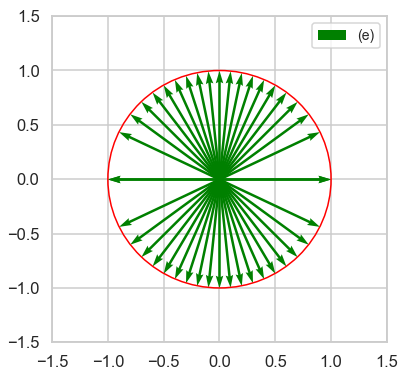

In [39]:
sns.set_style("whitegrid")
sns.set_context("talk", rc={"lines.linewidth": 2})
fig, ax = plt.subplots(figsize=(6,6))

unit_circle = plt.Circle((0, 0), 1, color='r', fill=False)
ax.add_artist(unit_circle)    

a = np.arange(-1,1.1,.1)
b = np.sqrt(1 - a**2)

for a_val, b_val in zip(a,b):
    ax.quiver([0], [0], [a_val], [b_val], angles='xy', scale_units='xy', scale=1, color=['g']) 
    ax.quiver([0], [0], [-a_val], [-b_val], angles='xy', scale_units='xy', scale=1, color=['g'])
    
ax.legend(['(e)'], fontsize=14, ncol=2)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

The constraint, $||e|| = 1$, is shown via the red circle. Our problem has now been transformed into: find the vector $e$ from those above that _maximizes_ the variance of the projections. 

This new constraint will make maximization a bit more difficult, specifically we are going to need to add a **lagrange multiplier**, in order to make sure that the solution is unit length. This leaves us with the resulting equation:

$$V = \frac{1}{n} \sum_{i=1}^n \Big(\sum_{j=1}^d x_{ij} e_j\Big)^2 - \overbrace{\lambda \Big( \big( \sum_{k=1}^d e_j^2\big) - 1\Big)}^\text{Lagrange Multiplier}$$

In case you are not familiar with the lagrange multiplier, a brief overview is below. If you are familiar, feel free to just skip past it.

### Lagrange Multiplier
The Lagrange Multiplier is a technique that allows you to find the min/max of a multivariable function, _when there is a constraint on the input values you can you_. For example, let's say that we wanted to find the maximum value of:

$$f(x, y) = 2x + y$$

Visually, that is a 2-dimensional sheet sitting in 3-dimensional space:

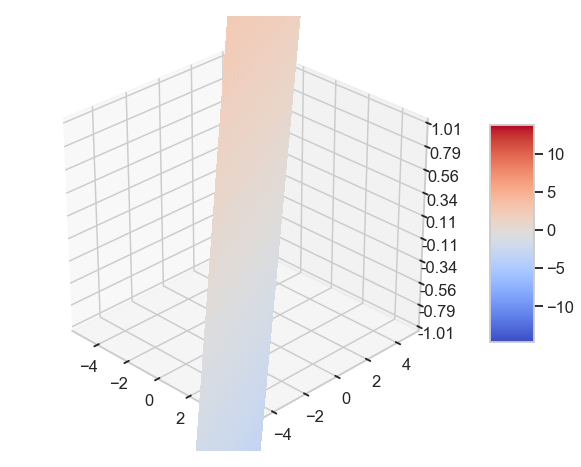

In [40]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = 2*X + Y

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(azim=-45)
plt.show()

In this case, a maximization can be achieved just by picking infinite values for $x$ and $y$. However, what if we add the following constraint:

$$g(x,y) = c$$

Where $g(x,y)$ is $x^2 + y^2$, and $c=1$, leaving us with:

$$x^2 + y^2 = 1$$

Visually, this would be:

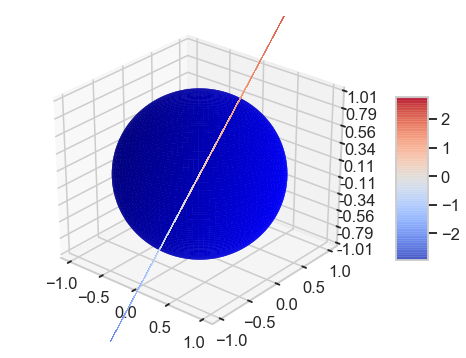

In [43]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')


# Make data.
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(X, Y)
Z = 2*X + Y

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.6, linewidth=0, antialiased=False)

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x_1 = r*sin(phi)*cos(theta)
y_1 = r*sin(phi)*sin(theta)
z_1 = r*cos(phi)

surf2 = ax.plot_surface(
    x_1, y_1, z_1,  rstride=1, cstride=1, color='b', linewidth=0)



# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(azim=-50)
plt.show()

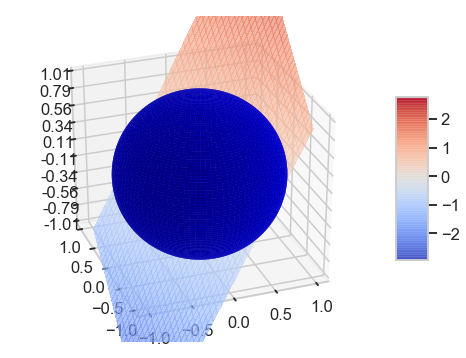

In [44]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')


# Make data.
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(X, Y)
Z = 2*X + Y

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.6, linewidth=0, antialiased=False)

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x_1 = r*sin(phi)*cos(theta)
y_1 = r*sin(phi)*sin(theta)
z_1 = r*cos(phi)

surf2 = ax.plot_surface(
    x_1, y_1, z_1,  rstride=1, cstride=1, color='b', linewidth=0)


# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(azim=-110)
plt.show()

So, we can see clearly that the point at which $f$ is maximized, subject to this constraint, is the highest point where the sphere, $g$, intersects $f$. Now, if we think about the **gradient** where $f$ and $g$ intersect, we can extend that to reasoning about the contour lines of $f$ and the contour lines of $g$ being _tangent_.

That is easy enough to process, but what exactly can we do with it? Well, if we bring back the gradient ($\nabla f$), we know that the gradient of $f$ evaluate at a point $(x_0, y_0)$ will always give a vector perpendicular to the countour line passing through that point. This means that when $f$ and $g$ are tangent, their gradient vectors are parallel. Now, we do not know the magnitude of each of these gradient vectors, but because we know that they point in the same direction at the point $(x_0, y_0)$, we can multiply one by a constant to get the other. This looks like:

$$\nabla f(x_0, y_0) = \lambda_0 \nabla g(x_0, y_0)$$

In our particular example, we can work out the math as follows:

$$\nabla f(x,y) = 
\begin{bmatrix}
    \frac{\partial}{\partial x} (2x + y) \\
    \frac{\partial}{\partial y} (2x + y)
\end{bmatrix} = 
\begin{bmatrix}
    2 \\
    1
\end{bmatrix} 
$$

$$\nabla g(x,y) = 
\begin{bmatrix}
    \frac{\partial}{\partial x} (x^2 + y^2 - 1) \\
    \frac{\partial}{\partial y} (x^2 + y^2 - 1) 
\end{bmatrix} = 
\begin{bmatrix}
    2x \\
    2y
\end{bmatrix} 
$$

Leaving us with a tangency condition of:

$$\begin{bmatrix}
    2 \\
    1
\end{bmatrix} = 
\lambda_0
\begin{bmatrix}
    2x_0 \\
    2y_0
\end{bmatrix} 
$$

We now have three equations:

$$x_0^2 + y_0^2 = 1$$

$$2 \lambda_0 x_0$$

$$2 \lambda_0 y_0$$

And three unknowns: $\lambda_0, x_0, y_0$

Which is a perfectly solvable situation. Now, where Lagrange came in was that he took the above scenario and created a special function from which all 3 equations above could be found. It looked like:

$$L(x,y,\lambda) = f(x,y) - \lambda(g(x,y) - c)$$

### Back to Eigenvectors...
Based on the above, it is fairly straight forward to see how our equation was determined:

$$V = \frac{1}{n} \sum_{i=1}^n \Big(\sum_{j=1}^d x_{ij} e_j\Big)^2 - \overbrace{\lambda \Big( \big( \sum_{k=1}^d e_j^2\big) - 1\Big)}^\text{Lagrange Multiplier}$$

Our constraint was equal to $1$, and our function $g$ was that representing the length of $e$. Now, we can take the derivative of the above equation and set it equal to 0:

$$\frac{\partial V}{\partial e_a} = \frac{2}{n} \sum_{i=1}^n \Big(\sum_{j=1}^d x_{ij} e_j\Big)x_{ia} - 2\lambda e_a = 0$$

Note that we are differentiating with respect to components of $e$. So, $e_a$ is the value of $e$ for attribute $a$. Hence, the above equation is representing the derivative for just one coordinate, but we will have many. As a next step, we can move things around as follows:

$$2 \sum_{j=1}^d e_j \Big( \frac{1}{n} \sum_{i=1}^n x_{ia} x_{ij}\Big) = 2\lambda e_a$$

The sums can be swapped since everything is linear. $e_j$ is moved outside of the inner sum since it does not depend on $i$, and is effectively a constant inside of that sum. We end up with the sum over $i$'s, which are our instances in the dataset, and we take the value of the $a$th attribute multiply it by the value of the $j$th attribute, and add the values up. This is the definition of the **covariance** between attribute $a$ and $j$. 

$$2 \sum_{j=1}^d e_j \overbrace{\Big( \frac{1}{n} \sum_{i=1}^n x_{ia} x_{ij}\Big)}^\text{covariance of a,j} = 2\lambda e_a$$

Keep in mind that we have one of the above equations for all attributes $a$, where $a$ is in $1..d$. Our entire equation set looks like:

$$
\begin{bmatrix}
    \sum_{j=1}^d cov(1,j) e_j = \lambda e_1 \\
    \vdots \\
    \sum_{j=1}^d cov(d,j) e_j = \lambda e_d
\end{bmatrix} 
$$

We have a sum from $j=1..d$, which is a sum over all of our attributes, then we have the covariance of the first attribute with $j$ times the value of $j$ in our vector $e$, which is then equal to $\lambda$, the lagrange multiplier, times $e_1$, the value of the first attribute in the vector. Another way to view it is that we are taking the first row of the covariance matrix $cov(1,j)$ (for all $j$, thanks to the sum), and taking the dot product with $e$: This could also be written without the summations:

$$cov(1, :) \cdot e$$

So, we see that the first row of the covariance matrix dotted with vector $e$ is the first component of vector $e$ times the lagrange multiplier. This is then repeated for all attributes $1..d$. Which, if we rewrite this in matrix notation and drop the sums, we end up with:

$$\sum e = \lambda e$$

Which is the eigenvector/value equation that we have seen before! Hence, $e$ _must_ be an eigenvector! So, we have just proved that the way to maximize the variance of our projections is to project onto an _eigenvector_. Curiously enough, our lagrange multiplier ends up being and eigenvalue. 

### 2.2.5 Eigenvalue is the variance along the Eigenvector
At this point we know that we are picking eigenvectors because they are good! But, we can actually quantify what the variance along the eigenvector is going to be. So, once again we are projecting all of our instances onto $e$, which is just the dot product:

$$x^T \cdot e$$

We then want to measure the variance along $e$, which we are now assuming to be an eigenvector. Again, this is:

$$\frac{1}{n} \sum_{i=1}^n \Big(\sum_{j=1}^d x_{ij} e_j - \mu\Big)^2 = \frac{1}{n} \sum_{i=1}^n \Big( \overbrace{\sum_{j=1}^d x_{ij} e_j }^\text{Dot Product}\Big)^2$$

We have dropped the mean of the projections(again claiming it is zero), but we can now discuss _why_ it is zero. The mean in the projection space can be rewritten as:

$$\mu = \frac{1}{n} \sum_{i=1}^n \Big(\sum_{j=1}^d x_{ij} e_j\Big)$$

Which we can then manipulate the sums to get the average of the $j$th attribute: 

$$\mu = \sum_{j=1}^d \Big( \frac{1}{n} \sum_{i=1}^n x_{ij}\Big)e_j$$

Recall, earlier we centered our data, meaning that the average of the $j$th attribute must be zero! Hence, we can drop this term. So, we can take our variance along the eigenvector $e$ and play around with it as follows:

$$\frac{1}{n} \sum_{i=1}^n \Big(\sum_{j=1}^d x_{ij} e_j\Big) \Big(\sum_{a=1}^d x_{ia} e_a\Big)$$

Above we have just broken out our two summations (they had been squared before), and now writing each on it's own with a unique subscript. Keep in mind, these two sums are _identical_. At this point we can move the sums around:

$$\sum_{a=1}^d \sum_{j=1}^d \Big( \overbrace{ \frac{1}{n} \sum_{i=1}^n x_{ia} x_{ij} }^\text{cov(a,j)}\Big) e_j e_a$$

And once again, we are have the covariance of attribute $a$ and $j$:

$$\sum_{a=1}^d\Big( \sum_{j=1}^d cov(a,j)e_j \Big) e_a$$

Which, from the same line of reasoning that we went over earlier, our covariance multiplication actually is just equal to:

$$\sum_{j=1}^d cov(a,j)e_j = \lambda e_a$$

Again, this is because we know that multiplying the $a$th row of the covariance matrix by the eigenvector $e$, and we know we are going to get back the $a$th eigenvector. This allows us to simplify our equation to:

$$\sum_{a=1}^d\Big(\lambda e_a \Big) e_a$$

And we can simplify that to:

$$\lambda ||e||^2 = \lambda$$

Where $||e||$ had unit length, so it just resolves to 1. So, we have just shown that the variance along the eigenvector $e$ is just the eigenvalue $\lambda$! 